In [1]:
import os, pathlib, pandas as pd

# Ensure CWD is repo root if opened from notebooks/
if pathlib.Path.cwd().name == "notebooks":
    os.chdir("..")
print("CWD:", pathlib.Path.cwd())

# Find newest parquet
cands = list(pathlib.Path("data/interim").glob("train_sample_*.parquet"))
assert cands, "No parquet samples found. Re-run the loader."
p = max(cands, key=lambda x: x.stat().st_mtime)
print("Loading:", p)

df = pd.read_parquet(p, engine="pyarrow")
df["dt"] = pd.to_datetime(df["dt"])
df.head(), df.shape

CWD: /Users/abhistaatchutuni/Desktop/freshretail-demand-forecasting
Loading: data/interim/train_sample_200000.parquet


(   city_id  store_id  management_group_id  first_category_id  \
 0        4       832                    2                 29   
 1        0       154                    6                  4   
 2        0       555                    6                  8   
 3        0       309                    6                  4   
 4       16       546                    2                 31   
 
    second_category_id  third_category_id  product_id         dt  sale_amount  \
 0                  76                 60         596 2024-04-10          0.7   
 1                  53                 58         578 2024-06-02          1.7   
 2                  29                115          99 2024-04-06          1.6   
 3                  28                180         118 2024-06-22          1.1   
 4                  79                230         549 2024-05-02          1.3   
 
                                           hours_sale  stock_hour6_22_cnt  \
 0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1

In [3]:
df.info()
df.isnull().sum().sort_values(ascending=False).head(10), df.describe(include="number")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   city_id              200000 non-null  int64         
 1   store_id             200000 non-null  int64         
 2   management_group_id  200000 non-null  int64         
 3   first_category_id    200000 non-null  int64         
 4   second_category_id   200000 non-null  int64         
 5   third_category_id    200000 non-null  int64         
 6   product_id           200000 non-null  int64         
 7   dt                   200000 non-null  datetime64[ns]
 8   sale_amount          200000 non-null  float64       
 9   hours_sale           200000 non-null  object        
 10  stock_hour6_22_cnt   200000 non-null  int32         
 11  hours_stock_status   200000 non-null  object        
 12  discount             200000 non-null  float64       
 13  holiday_flag  

(city_id               0
 stock_hour6_22_cnt    0
 avg_humidity          0
 avg_temperature       0
 precpt                0
 activity_flag         0
 holiday_flag          0
 discount              0
 hours_stock_status    0
 hours_sale            0
 dtype: int64,
              city_id       store_id  management_group_id  first_category_id  \
 count  200000.000000  200000.000000        200000.000000       200000.00000   
 mean        4.996885     409.558690             4.623170           15.22043   
 std         6.099192     248.823084             1.958951            8.96836   
 min         0.000000       0.000000             0.000000            0.00000   
 25%         0.000000     195.000000             3.000000            5.00000   
 50%         0.000000     395.000000             6.000000           16.00000   
 75%        12.000000     599.000000             6.000000           21.00000   
 max        17.000000     897.000000             6.000000           31.00000   
 
        secon

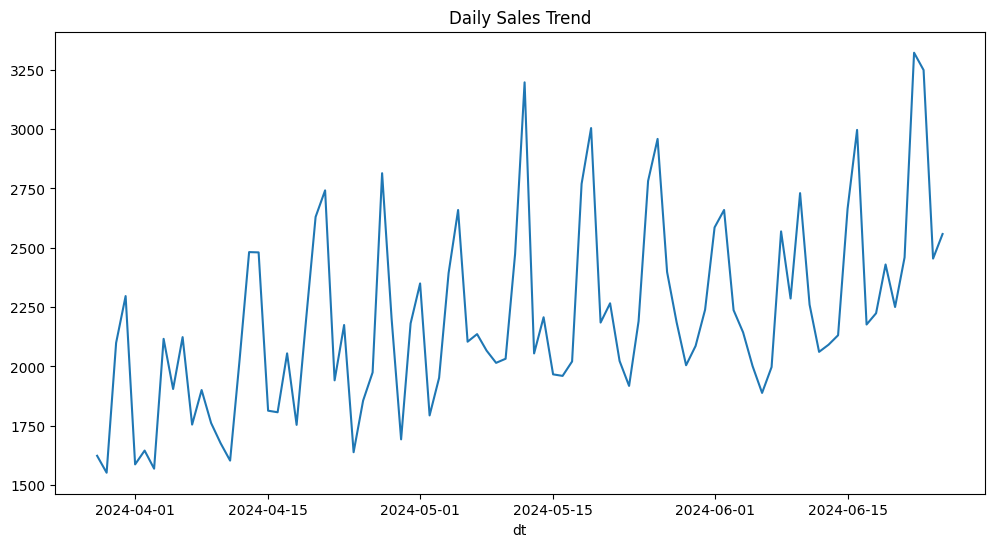

In [4]:
import matplotlib.pyplot as plt
daily = df.groupby(df["dt"].dt.date)["sale_amount"].sum()
daily.plot(figsize=(12,6), title="Daily Sales Trend"); plt.show()

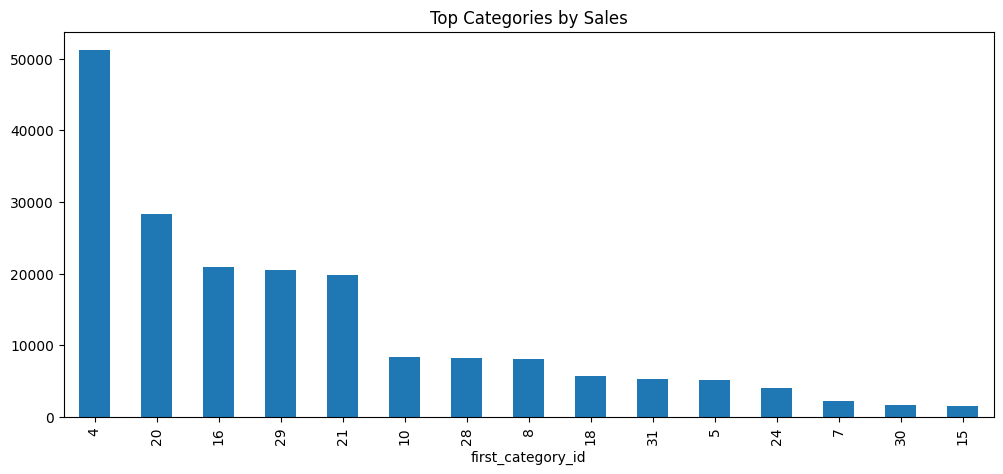

In [5]:
(df.groupby("first_category_id")["sale_amount"]
   .sum().sort_values(ascending=False).head(15)
   .plot(kind="bar", figsize=(12,5), title="Top Categories by Sales")); plt.show()

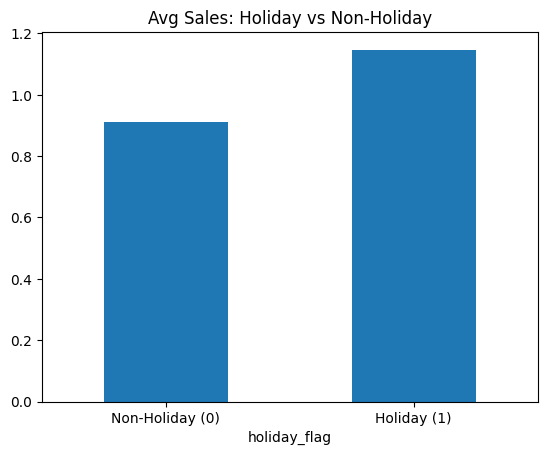

In [6]:
ax = df.groupby("holiday_flag")["sale_amount"].mean().plot(kind="bar", title="Avg Sales: Holiday vs Non-Holiday")
ax.set_xticklabels(["Non-Holiday (0)","Holiday (1)"], rotation=0); plt.show()

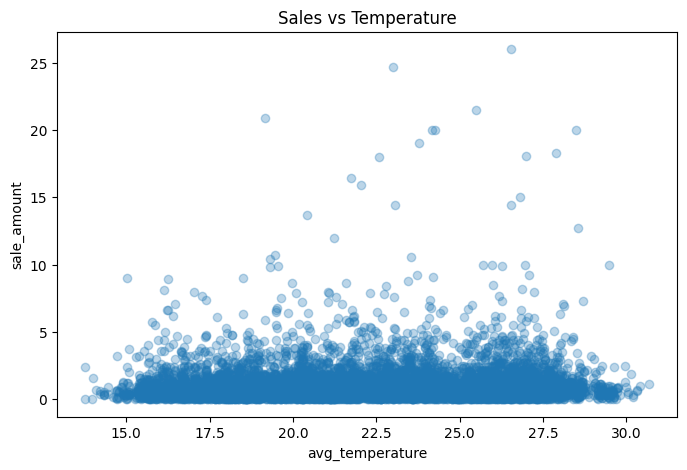

In [7]:
s = df.sample(min(10000, len(df)), random_state=42)
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(s["avg_temperature"], s["sale_amount"], alpha=0.3)
ax.set(title="Sales vs Temperature", xlabel="avg_temperature", ylabel="sale_amount"); plt.show()

<Axes: title={'center': 'Average Sales by Hour'}, xlabel='hour'>

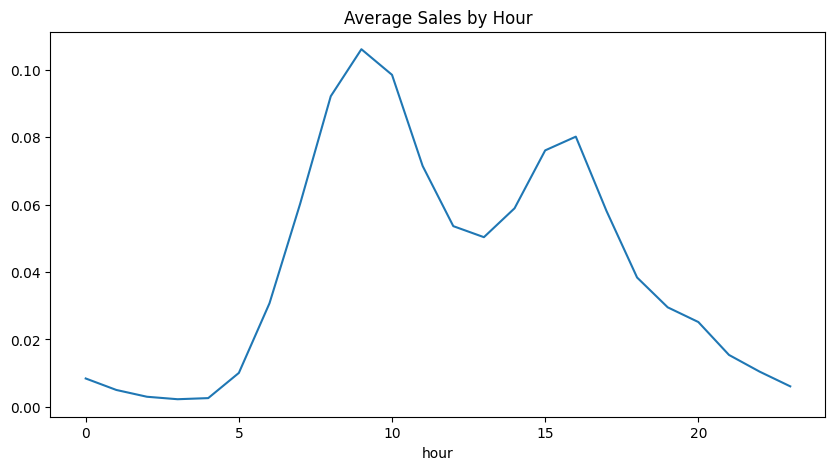

In [9]:
import numpy as np

# Expand hours_sale (list of 24 hourly sales per row) into long format
expanded = (
    df[["product_id", "store_id", "dt", "hours_sale"]]
    .explode("hours_sale")
    .assign(hour=lambda x: x.groupby(["product_id","store_id","dt"]).cumcount())
)

expanded["hours_sale"] = expanded["hours_sale"].astype(float)

# Now aggregate: avg sales per hour
avg_hourly = expanded.groupby("hour")["hours_sale"].mean()

avg_hourly.plot(figsize=(10,5), title="Average Sales by Hour")